In [2]:
import numpy as np
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [4]:
def load_embeddings(file_path):
    return torch.load(file_path).cpu().numpy()  # Convert to NumPy for calculations

def Cosine_distance(test_sample, train_sample):
    dot_product = np.dot(test_sample, train_sample)

    norm_text = np.linalg.norm(test_sample)
    norm_train = np.linalg.norm(train_sample)
    
    if norm_text == 0 or norm_train == 0:
        return 1.0

    cosine_similarity = dot_product / (norm_text * norm_train)
    
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

In [5]:
def find_n_probe_clusters(test_point, kmeans, nprobe=4):
    distances = []

    for center in kmeans.cluster_centers_:
        euclid_distance = Cosine_distance(test_point, center)
        distances.append(euclid_distance)

    sorted_indices = sorted(enumerate(distances), key=lambda x: x[1])
    
    closest_cluster_indices = []

    for cluster_idx, _ in sorted_indices[:nprobe]:
        closest_cluster_indices.append(cluster_idx)
    
    return closest_cluster_indices

In [6]:
def find_k_nearest_neighbours(train_embeddings, train_labels, nearest_clusters, test_point, cluster_indices):
    k = 100
    distances = []

    for cluster_index in nearest_clusters:
        for train_point in cluster_indices.get(cluster_index, []):  # Use .get() to avoid KeyError
            dist = Cosine_distance(test_point, train_embeddings[train_point])
            distances.append((dist, train_point))

    distances.sort(key=lambda x: x[0])

    return [idx for _, idx in distances[:min(k, len(distances))]]

In [7]:
def mean_reciprocal_rank(nearest_neighbors, train_labels, test_labels):
    mrr = 0.0
    for i in range(len(nearest_neighbors)):
        true_label = test_labels[i]

        neighbors = nearest_neighbors[i]

        for rank, neighbor_idx in enumerate(neighbors):
            if train_labels[neighbor_idx] == true_label:
                mrr += 1 / (rank + 1)
                break
        
    return mrr / len(nearest_neighbors)

def precision_at_k(nearest_neighbors, train_labels, test_labels, k=100):
    precision = 0.0
    for i in range(len(nearest_neighbors)):
        true_label = test_labels[i] 
        neighbors = nearest_neighbors[i]

        relevant_count = 0
        for neighbor_idx in neighbors[:k]:
            if train_labels[neighbor_idx] == true_label:
                relevant_count += 1
        precision += relevant_count / k
        
    return precision / len(nearest_neighbors)

def hit_rate_at_k(nearest_neighbors, train_labels, test_labels,k=100):
    hits = 0
    for i in range(len(nearest_neighbors)):
        true_label = test_labels[i] 
        neighbors = nearest_neighbors[i]

        if any(train_labels[neighbor_idx] == true_label for neighbor_idx in neighbors[:k]):
            hits += 1
        
    return hits / len(nearest_neighbors)

In [8]:
train_embeddings = load_embeddings('SMAI A1-20250202T180732Z-001/SMAI A1/train_embeddings.pth')  # Replace with actual path
train_labels = load_embeddings('SMAI A1-20250202T180732Z-001/SMAI A1/train_labels.pth')
test_embeddings = load_embeddings('SMAI A1-20250202T180732Z-001/SMAI A1/test_embeddings.pth')
test_labels = load_embeddings('SMAI A1-20250202T180732Z-001/SMAI A1/test_labels.pth')

In [9]:
n_probes = [1,2,3]

In [10]:
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(train_embeddings)

cluster_labels = kmeans.labels_

cluster_indices = {}

for idx, cluster_id in enumerate(cluster_labels):
    if cluster_id not in cluster_indices:
        cluster_indices[cluster_id] = []  # Initialize list for new cluster
    cluster_indices[cluster_id].append(idx)

In [29]:

for nprobe in n_probes:
    nearest_neighbours = []
    print(f"The value of nprobe is {nprobe}")
    for test_point in test_embeddings:
        nearest_clusters = find_n_probe_clusters(test_point, kmeans, nprobe)
        nearest_embeds = find_k_nearest_neighbours(train_embeddings, train_labels, nearest_clusters, test_point, cluster_indices)
        nearest_neighbours.append(nearest_embeds)

    mrr = mean_reciprocal_rank(nearest_neighbours, train_labels, test_labels)
    print(f"MRR: {mrr}")

    precision = precision_at_k(nearest_neighbours, train_labels, test_labels, k=100)
    hit_rate = hit_rate_at_k(nearest_neighbours, train_labels, test_labels, k=100)

    print(f"Precision@100: {precision}")
    print(f"Hit Rate@100: {hit_rate}")

The value of nprobe is 1
MRR: 0.9265684557243083
Precision@100: 0.8353769999999647
Hit Rate@100: 0.9985
The value of nprobe is 2
MRR: 0.9337073350074765
Precision@100: 0.8406339999999658
Hit Rate@100: 0.9991
The value of nprobe is 3
MRR: 0.934433987656303
Precision@100: 0.8416579999999653
Hit Rate@100: 0.9993


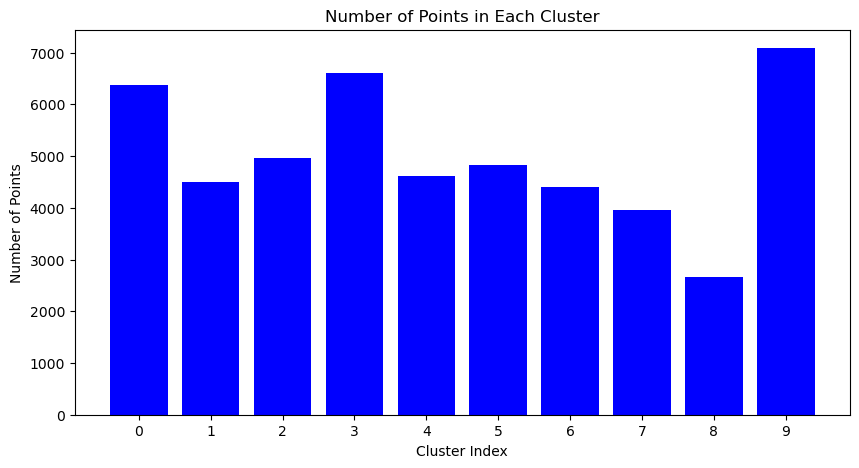

In [11]:
cluster_sizes = [len(cluster_indices[i]) for i in range(num_clusters)]
plt.figure(figsize=(10, 5))
plt.bar(range(num_clusters), cluster_sizes, color='blue')
plt.xlabel('Cluster Index')
plt.ylabel('Number of Points')
plt.title('Number of Points in Each Cluster')
plt.xticks(range(num_clusters))
plt.show()

In [12]:
def compute_avg_comparisons(nprobe_values, test_embeddings, kmeans, cluster_indices):
    avg_comparisons = []
    
    for nprobe in nprobe_values:
        total_comparisons = 0
        for test_point in test_embeddings:
            nearest_clusters = find_n_probe_clusters(test_point, kmeans, nprobe)
            comparison_count = sum(len(cluster_indices.get(cluster, [])) for cluster in nearest_clusters)
            total_comparisons += comparison_count
        avg_comparisons.append(total_comparisons / len(test_embeddings))
    
    return avg_comparisons

[5330.7593, 10766.7573, 16192.8844]


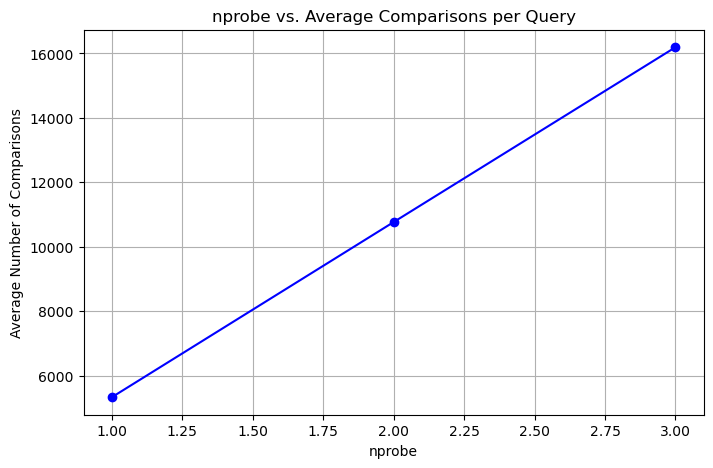

In [13]:
avg_comparisons = compute_avg_comparisons(n_probes, test_embeddings, kmeans, cluster_indices)
print(avg_comparisons)
plt.figure(figsize=(8, 5))
plt.plot(n_probes, avg_comparisons, marker='o', linestyle='-', color='b')
plt.xlabel('nprobe')
plt.ylabel('Average Number of Comparisons')
plt.title('nprobe vs. Average Comparisons per Query')
plt.grid(True)
plt.show()

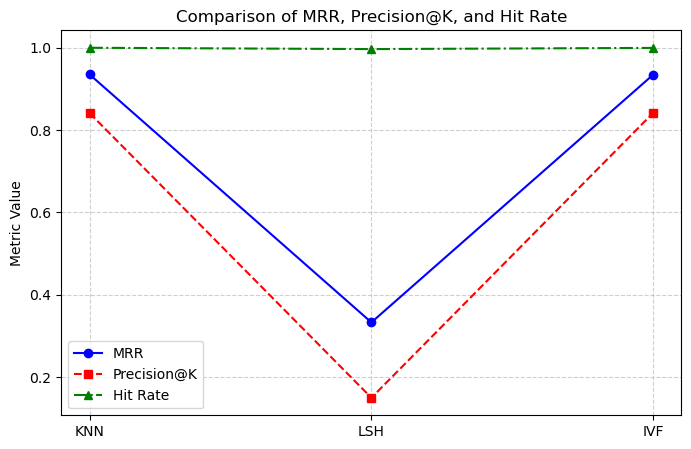

In [14]:
MRR = [0.9347961513315047, 0.3329733313110391, 0.934433987656303]
Precision_at_k = [0.8410819999999664, 0.1499859999999951, 0.8416579999999653]
Hit_Rate = [0.9996, 0.9964, 0.9993]

labels = ["KNN", "LSH", "IVF"]

# X-axis positions
x = np.arange(len(labels))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, MRR, marker='o', linestyle='-', label="MRR", color='b')
plt.plot(x, Precision_at_k, marker='s', linestyle='--', label="Precision@K", color='r')
plt.plot(x, Hit_Rate, marker='^', linestyle='-.', label="Hit Rate", color='g')

# Labels and title
plt.xticks(x, labels)
plt.ylabel("Metric Value")
plt.title("Comparison of MRR, Precision@K, and Hit Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()

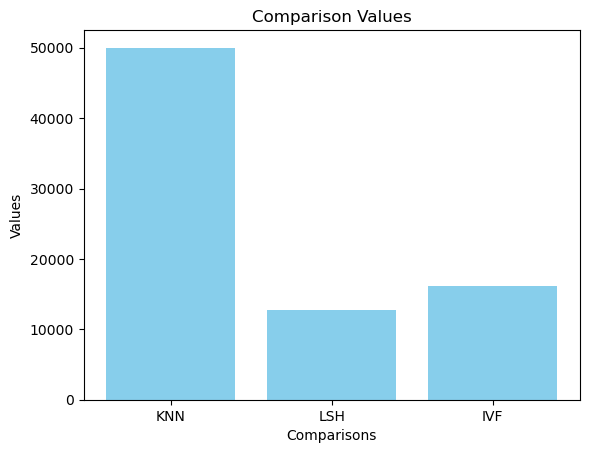

In [16]:
comparison = [50000.0, 12774.6778, 16192.8844]

comparisons = [50000.0, 12774.6778, 16192.8844]
labels = ['KNN', 'LSH', 'IVF']

# Plotting
plt.bar(labels, comparisons, color='skyblue')
plt.title('Comparison Values')
plt.xlabel('Comparisons')
plt.ylabel('Values')
plt.show()